# Training an LSTM network on the Penn Tree Bank (PTB) dataset - Part II: TensorFlow eager execution  
---

## Introduction

Long Short-Term Memory (LSTM) networks were first proposed by Sepp Hochreiter and [Jürgen Schmidhuber][1] in 1997 for modeling sequence data. [Christopher Olah][2] has nicely illustrated how they work. The fifth course in the [deep learning specialization][3] on Coursera teaches recurrent neural networks (RNN), of which the LSTM is a variant, in detail, and explains many interesting applications. For a succinct summary of the mathematics of these models, see, for example, [Stanford cs231n lecture 10][4] or [Greff, et al. (2016)][5].

This is Part II of a series of illustrative examples of training an LSTM network. In these examples, an LSTM network is trained on the Penn Tree Bank (PTB) dataset to replicate some previously published work. The PTB dataset is an English corpus available from Tomáš Mikolov's web [page][6], and used by many researchers in language modeling experiments. It contains 929K training words, 73K validation words, and 82K test words. It has 10K words in its vocabulary. Wojciech Zaremba, Ilya Sutskever, and Oriol Vinyals used this dataset in their ICLR 2015 [paper][7] where they showed that the correct place to implement dropout regularization in an RNN is in the connections between layers and not between time steps. To demonstrate the effectiveness of their regularization strategy, they reported word-level perplexities on the PTB dataset with three different networks: a "small" non-regularized LSTM, a "medium" regularized LSTM, and a "large" regularized LSTM. It is their "small" non-regularized LSTM model that is replicated in these examples.  

Part I of this series presents an object-oriented design of the non-regularized LSTM network implemented in pure [Python][8]/[Numpy][9]. Equations are coded up from scratch to carry out the computations without dependencies on extraneous frameworks or libraries. This is a minimalist implementation, partly inspired by Andrej Karpathy's [minimalist character-level language model][14]. The program is executed on a CPU. 

Part II (i.e. this notebook) shows how the same model can be easily implemented using [TensorFlow][10], the open-source framework originally developed by researchers and engineers from the Google Brain team within Google’s AI organization. The model is programmed in TensorFlow's "[eager execution][11]" imperative programming environment that evaluates operations immediately without building dataflow graphs. This is akin to regular Python programming following Python control flow. The program is executed in [Colaboratory][12] with GPU acceleration.

Part III demonstrates how the model can be implemented using TensorFlow's low-level programming model in which you first define the dataflow [graph][13] and then create a TensorFlow [session][13] to run parts of the graph. In a dataflow graph, the nodes (ops) represent units of computation, and the edges (tensors) represent the data consumed or produced by a computation. Calling most functions in the TensorFlow low-level API merely adds operations and tensors to the default graph, but does not perform the actual computation. Instead, you compose these functions until you have a tensor or operation that represents the overall computation, such as performing one step of gradient descent, and then pass that object to a TensorFlow session to run the computation. This model is different from the familiar imperative model, but is a common model for parallel computing. The program is executed in [Colaboratory][12] with GPU acceleration.

It is shown that all these implementations yield results which agree with each other and with those in Zaremba et al. (2015).

[1]: http://people.idsia.ch/~juergen/
[2]: http://colah.github.io/posts/2015-08-Understanding-LSTMs/
[3]: https://www.coursera.org/specializations/deep-learning
[4]: http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture10.pdf
[5]: https://arxiv.org/abs/1503.04069
[6]: http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
[7]: https://arxiv.org/abs/1409.2329
[8]: https://www.python.org/
[9]: http://www.numpy.org/
[10]: https://www.tensorflow.org/
[11]: https://www.tensorflow.org/guide/eager
[12]: https://colab.research.google.com/notebooks/welcome.ipynb
[13]: https://www.tensorflow.org/guide/graphs
[14]: https://gist.github.com/karpathy/d4dee566867f8291f086
[15]: https://github.com/tensorflow/models/tree/master/tutorials/rnn/ptb
[16]: https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager/python/examples/rnn_ptb

---

## Implementing an LSTM network with TensorFlow "eager execution"
The implementation is similar to [this][16] TensorFlow tutorial example, but differs in the following respects:
1. This implementation depends on TensorFlow API that requires an Nvidia GPU to run. The tutorial example switches API depending on whether GPU is available or not, and so can run on either GPU or CPU. 
2. This implementation uses `tf.data.Dataset` for the input pipeline whereas the tutorial predates the Dataset API.

There is only one class, PTBModel, which is responsible for:
1. Configuring the network layers. The `__init__` method of the PTBModel class configures the network layers. 
2. The `train` method trains an epoch. The `evaluate` method evaluates an epoch. 

In [0]:
#MIT License - Copyright (c) 2018 tmatha

import tensorflow as tf
import numpy as np
import logging
import time
import math
import datetime
import collections
import matplotlib.pyplot as plt

tf.enable_eager_execution()#execute only once after starting kernel

In [0]:
#MIT License - Copyright (c) 2018 tmatha

class PTBModel(object):
  """
  LSTM network for language modeling for training/evaluation/testing on the PTB
  dataset. Model similar to the TensorFlow eager execution tutorial example at
  https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager/
  python/examples/rnn_ptb. 
  The main differences are:
    
  -The tutorial uses tf.contrib.cudnn_rnn.CudnnLSTM when running on Nvidia GPU, 
   and tf.nn.rnn_cell.BasicLSTMCell when GPU is not available. This model only  
   uses tf.contrib.cudnn_rnn.CudnnLSTM and so Nvidia GPU is always required. 
  -This model uses tf.data.Dataset for the input pipe line where as the tutorial
   predates the Dataset API.
  
  Ref: 
    Wojciech Zaremba, Ilya Sutskever, and Oriol Vinyals, 
    "Recurrent Neural Network Regularization", ICLR 2015
    
  Imports:
    tf
    tf.nn
    tf.math
    tf.contrib.cudnn_rnn.CudnnLSTM - requires GPU
    tf.layers.Dense
    tf.train.GradientDescentOptimizer
    tf.contrib.eager
  
  """
  
  def __init__(self, 
               vocab_size, 
               embedding_dim, 
               hidden_dim, 
               num_layers, 
               initializer, 
               dropout_ratio):
    """Initalizes a model instance. Configures network layers.
    
    Args:
      vocab_size: int;
      embedding_dim: int; 
      hidden_dim: int; hidden state size, cell state size
      num_layers: int; number of layers
      initializer: initializer object for initializing kernels and biases
      dropout_ratio: float; drop out ratio

    Returns:
      a model instance

    Raises:
      
    """
    self._embedding=tf.get_variable(
        'embedding',
        shape=(vocab_size, embedding_dim),
        initializer=initializer,
        trainable=True)
    
    #crashes when input_mode='skip_input' or 'auto_select'
    self._rnn=tf.contrib.cudnn_rnn.CudnnLSTM(
        num_layers=num_layers, 
        num_units=hidden_dim, 
        dropout=dropout_ratio,
        kernel_initializer=initializer,
        input_mode='linear_input')
 
    self._dense=tf.layers.Dense(
        units=vocab_size,        
        kernel_initializer=initializer)
        
    self._training=False
    self._state=None
    
  def _call(self,inp):
    """Executes a forward prop through the network.
    
    Args:
      inp: input (features) tf.int64 2-d tensor of shape (seq_len,batch_size)
      
    Returns:
      y: output logits tf.float32 3-d tensor of shape (seq_len,batch_size,
        vocab_size)
        
    Raises:
      
    """
    
    y=tf.nn.embedding_lookup(self._embedding, inp)     
    y,self._state=self._rnn(y,initial_state=self._state,training=self._training)
    y=self._dense(y)
    
    return y
  
  def _loss(self, inp, target):
    """Calls forward prop, gets logits, computes softmax, and calculates total
    cross-entropy loss for a mini batch.
    
    Args:
      inp: input (features) tf.int64 2-d tensor of shape (seq_len,batch_size)
      target: target (labels) tf.int64 2-d tensor of shape (seq_len,batch_size)
      
    Returns:
      loss: tf.float32 0-d tensor
        
    Raises:
      
    """
    
    y=self._call(inp)
    return tf.math.reduce_sum(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=target,logits=y))
  
  def train(self, iterator, clip_norm, optimizer):
    """Runs an epoch of training.
        
    Args:
      iterator: iterator object that yields (input,target) tuples where input  
        and target both are tf.int64 2-d tensors of shape (seq_len,batch_size)
      clip_norm: float; maximum global norm for clipping gradients
      optimizer: optimizer object for applying gradients
      
    Returns:
      A python list of losses, one loss (float) per step
      
    Raises:
    
    """
    self._training=True
    self._state=None
    losses=[]
    
    while True:
      try:
        inp,target=iterator.get_next()
        loss,grad_var=tf.contrib.eager.implicit_value_and_gradients(self._loss)(
            inp,target)
        losses.append(loss.numpy())
        
        gradients,variables=zip(*grad_var)
        clipped, global_norm=tf.clip_by_global_norm(gradients, clip_norm)
        grad_var=zip(clipped, variables)
        optimizer.apply_gradients(grad_var)
      except tf.errors.OutOfRangeError:
        break
        
    return losses
        
  def evaluate(self, iterator):
    """Runs an epoch of evaluation.
        
    Args:
      iterator: iterator object that yields (input,target) tuples where input 
        and target both are tf.int64 2-d tensors of shape (seq_len,batch_size)
      
    Returns:
      A python list of losses, one loss (float) per step
      
    Raises:
    
    """
    self._training=False
    self._state=None
    losses=[]
    
    while True:
      try:
        inp,target=iterator.get_next()       
        losses.append(self._loss(inp,target).numpy())
      except tf.errors.OutOfRangeError:
        break
        
    return losses

  @classmethod
  def instance(cls, model_type='small', vocab_size=10000):
    """Returns a model instance.
    
    Args:
      model_type: string; 'small', 'medium' or 'large'; only 'small' is
        implemented presently
      vocab_size: int;

    Returns:
      a model instance

    Raises:
      
    """
    return {
        'small':PTBModel(
            vocab_size=vocab_size,
            embedding_dim=200,
            hidden_dim=200,
            num_layers=2,
            initializer=tf.random_uniform_initializer(minval=-0.1,maxval=0.1),
            dropout_ratio=0.),
        'medium':None,
        'large':None
        }.get(model_type,None)

---

## Data shaping
In language modeling, both input (feature) and target (label) sequences are formed from the same original sequence. The target sequence is simply the input sequence itself advanced by one time step. Both input and target data have to be fed to the model in chunks or mini batches of the requisite shape. The requisite shape differes from API to API; some (e.g. `tf.keras.layers.CuDNNLSTM`) require mini batches of shape (batch size, sequence length), whereas others (e.g. `tf.contrib.cudnn_rnn.CudnnLSTM`) call for mini batches of shape (sequence length, batch size). Here, sequence length is the length of the RNN layer or subsequence, and batch size is the number of subsequences processed together in one step of gradient descent. In other words, gradients are computed and applied for a full mini batch at each step of gradient descent, and it takes "steps" number of mini batches to cover an epoch. If the data doesn't divide cleanly into an integral number of mini batches, the last remaining data is dropped. The following fuction takes a 1-d data sequence and returns a tuple of input and target arrays to be fed to a Dataset which in turn has to feed correctly-shaped mini batches to the model. The original sequential order is preserved throughout except for having to split the original sequence into the requisite number of subsequences to be processed together. This entails in-memory data array.

In [0]:
#MIT License - Copyright (c) 2018 tmatha

def features_labels(data_array,batch_size,seq_len,batch_first=True):
  """Splits the sequential data into batch_size number of sub_sequences and 
  folds them into the requisite shape. This procedure is applied to the data to 
  derive the features array. This procedure is repeated to derive the labels 
  array also, except in this case the data is shifted by one time step. 
  Returns a named tuple of features and labels.
  
  Args:
    data_array: np.int64 1-d numpy array of shape (size,)
    batch_size: int;
    seq_len: int; length of the rnn layer
    batch_first: boolean; the returned numpy arrays will be of shape 
      (batch_size*steps, seq_len) if True and 
      (seq_len*steps, batch_size) if False
      
  Returns:
    named tuple of features and labels, features and labels are np.int64 2-d 
      numpy arrays of shape (batch_size*steps, seq_len) if batch_first is True 
      and (seq_len*steps, batch_size) if batch_first is False
    steps: int; number of mini batches in an epoch
      
  Raises:
    ValueError: If input data_array is not 1-d

  """
  if len(data_array.shape) != 1:
    raise ValueError('Expected 1-d data array, '
                     'instead data array shape is {} '.format(data_array.shape))
  
  def fold(used_array):
    shaped_array=np.reshape(used_array,(batch_size,seq_len*steps),order='C')
    
    if batch_first:
      return np.concatenate(np.split(shaped_array,steps,axis=1),axis=0)
    else:
      return np.transpose(shaped_array)

  steps=(data_array.shape[0]-1)//(batch_size*seq_len)
  used=batch_size*seq_len*steps
  
  features=fold(data_array[:used])
  labels=fold(data_array[1:used+1])
  
  Data=collections.namedtuple('Data',['features','labels'])
  return Data(features=features,labels=labels),steps

---

## Training and evaluation
The non-regularized LSTM network, as in [Zaremba et al. (2015)][7], is configured and trained on the [Penn Tree Bank dataset][6]. Training the network for 13 epochs in [Colaboratory][12] with GPU acceleration takes less than 9 minutes. The trained network is shown to replicate word-level perplexities previously reported.

[6]: http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
[7]: https://arxiv.org/abs/1409.2329
[12]: https://colab.research.google.com/notebooks/welcome.ipynb

INFO:root:date 2018-11-04 06:37:45.471757
INFO:root:device /device:GPU:0
INFO:root:TensorFlow vers. 1.12.0-rc2
INFO:root:['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec']
INFO:root:['consumers', 'may', 'want', 'to', 'move', 'their', 'telephones', 'a', 'little', 'closer']
INFO:root:['no', 'it', 'was', "n't", 'black', 'monday', '<eos>', 'but', 'while', 'the']
INFO:root:size_train 929589, size_valid 73760, size_test 82430
INFO:root:vocab_train 10000, vocab_valid 6022, vocab_test 6049



                        TRAINING
time      epochs         loss               perplexity
                    train    valid       train       valid
======    ======    =====    =====       =====       =====
0:00:44     1.00     5.60     5.22      270.93      185.33
0:01:25     2.00     4.92     5.00      136.55      148.93
0:02:07     3.00     4.66     4.94      105.28      139.41
0:02:48     4.00     4.49     4.90       88.71      134.79
0:03:29     5.00     4.23     4.80       68.40      121.44
0:04:10     6.00     4.03     4.79       56.43      120.15
0:04:51     7.00     3.92     4.79       50.33      120.69
0:05:33     8.00     3.86     4.79       47.28      120.83
0:06:13     9.00     3.82     4.79       45.71      120.72
0:06:54    10.00     3.80     4.79       44.87      120.45
0:07:35    11.00     3.79     4.79       44.39      120.03
0:08:15    12.00     3.79     4.78       44.12      119.65
0:08:56    13.00     3.78     4.78       43.98      119.41


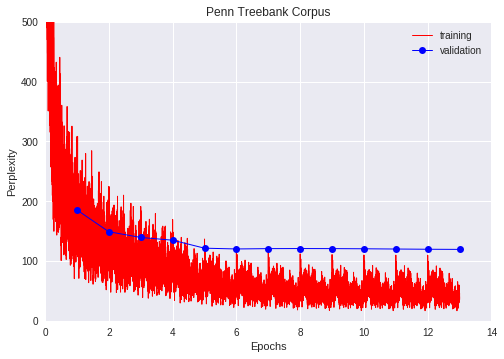

INFO:root:execution time - 0:08:58s



Loss/perplexity on test set after 13 epochs:     4.73/  113.64



In [15]:
#MIT License - Copyright (c) 2018 tmatha
#*******************************************************************************
# ---------------------- set up -----------------------------------------------*
#                                                                              *
#*******************************************************************************
start_time=time.time()
logging.basicConfig(level=logging.INFO)
logging.info('date {}'.format(datetime.datetime.now()))
logging.info('device {}'.format(tf.test.gpu_device_name()))
logging.info('TensorFlow vers. {}'.format(tf.__version__))
assert tf.test.is_gpu_available()

#*******************************************************************************
# ------------------ hyper parameters -----------------------------------------*
#                                                                              *
#*******************************************************************************
batch_size=20
seq_len=20
clip_norm=5
learning_rate=1.
decay=0.5
epochs=13
epochs_no_decay=4

#*******************************************************************************
# ---------------- data: Python lists of strings ------------------------------*
#                                                                              *
#*******************************************************************************
with open('ptb.train.txt','r') as f1,open('ptb.valid.txt','r') as f2,open(
    'ptb.test.txt','r') as f3:
    seq_train=f1.read().replace('\n','<eos>').split(' ')
    seq_valid=f2.read().replace('\n','<eos>').split(' ')
    seq_test=f3.read().replace('\n','<eos>').split(' ')

seq_train=list(filter(None,seq_train))
seq_valid=list(filter(None,seq_valid))
seq_test=list(filter(None,seq_test))

logging.info(seq_train[:10])
logging.info(seq_valid[:10])
logging.info(seq_test[:10])

size_train=len(seq_train)
size_valid=len(seq_valid)
size_test=len(seq_test)
logging.info('size_train {}, size_valid {}, size_test {}'.format(
    size_train,size_valid,size_test))

vocab_train=set(seq_train)
vocab_valid=set(seq_valid)
vocab_test=set(seq_test)

assert vocab_valid.issubset(vocab_train)
assert vocab_test.issubset(vocab_train)
logging.info('vocab_train {}, vocab_valid {}, vocab_test {}'.format(
    len(vocab_train),len(vocab_valid),len(vocab_test)))

vocab_train=sorted(vocab_train)#must have deterministic ordering, so word2id 
                               #dictionary is reproducible across invocations
word2id={w:i for i,w in enumerate(vocab_train)}
id2word={i:w for i,w in enumerate(vocab_train)}

#*******************************************************************************
# -- data: np.int64 1-d numpy arrays -> np.int64 2-d numpy arrays of shape ----*
# -- (seq_len*steps, batch_size) ----------------------------------------------*
#                                                                              *
#*******************************************************************************
#Note tf.contrib.cudnn_rnn.CudnnLSTM requires input tensor to be of shape 
#(seq_len,batch_size,embedding_dim), where as tf.keras.layers.CuDNNLSTM 
#requires input tensor to be of shape (batch_size,seq_len,embedding_dim)
ids_train=np.array([word2id[word] for word in seq_train],copy=False,order='C')
ids_valid=np.array([word2id[word] for word in seq_valid],copy=False,order='C')
ids_test=np.array([word2id[word] for word in seq_test],copy=False,order='C')

data_train,steps_train=features_labels(
    ids_train,batch_size,seq_len,batch_first=False)
data_valid,steps_valid=features_labels(
    ids_valid,batch_size,seq_len,batch_first=False)
data_test,steps_test=features_labels(
    ids_test,batch_size,seq_len,batch_first=False)

#*******************************************************************************
# ------------------------- datasets ------------------------------------------*
#                                                                              *
#*******************************************************************************
dataset_train=tf.data.Dataset.from_tensor_slices(data_train).batch(seq_len,
    drop_remainder=True)
dataset_valid=tf.data.Dataset.from_tensor_slices(data_valid).batch(seq_len,
    drop_remainder=True)
dataset_test=tf.data.Dataset.from_tensor_slices(data_test).batch(seq_len,
    drop_remainder=True)

#*******************************************************************************
# --------------------  model, optimizer --------------------------------------*
#                                                                              *
#*******************************************************************************
model=PTBModel.instance(model_type='small',vocab_size=len(word2id))
lr=tf.contrib.eager.Variable(initial_value=learning_rate, trainable=False)
optimizer=tf.train.GradientDescentOptimizer(lr)

#*******************************************************************************
# ------------------------- initialize ----------------------------------------*
#                                                                              *
#*******************************************************************************
perplexity_train=[]
perplexity_valid=[]

print('\n'+' '*24+'TRAINING'+'\n'+
      'time'+' '*6+
      'epochs'+' '*9+
      'loss'+' '*15+
      'perplexity'+'\n'+
      ' '*20+
      'train'+' '*4+
      'valid'+' '*7+
      'train'+' '*7+
      'valid'+'\n'+
      '======'+' '*4+
      '======'+' '*4+
      '====='+' '*4+
      '====='+' '*7+
      '====='+' '*7+
      '=====')

#*******************************************************************************
# ---------------------- train and evaluate -----------------------------------*
#                                                                              *
#*******************************************************************************
for epoch in range(epochs):
  iter_train=dataset_train.make_one_shot_iterator()
  losses_train=model.train(iter_train,clip_norm,optimizer)
  assert len(losses_train)==steps_train
  loss_train_avg=sum(losses_train)/(len(losses_train)*seq_len*batch_size)
  perplexity_train+=[(epoch+(step+1)/len(losses_train),math.exp(loss/(
      seq_len*batch_size))) for step,loss in enumerate(losses_train)]
  
  iter_valid=dataset_valid.make_one_shot_iterator()
  losses_valid=model.evaluate(iter_valid)
  assert len(losses_valid)==steps_valid
  loss_valid_avg=sum(losses_valid)/(len(losses_valid)*seq_len*batch_size)
  perplexity_valid.append((epoch+1,math.exp(loss_valid_avg)))
  
  if epoch>epochs_no_decay-2:
    lr.assign(lr*decay)

  print('{:}'.format(datetime.timedelta(seconds=round(time.time()-start_time))),
        '{:5.2f}'.format(epoch+1),
        '{:5.2f}'.format(loss_train_avg),
        '{:5.2f}'.format(loss_valid_avg),
        '{:8.2f}'.format(math.exp(loss_train_avg)),
        '{:8.2f}'.format(perplexity_valid[-1][1]),sep=' '*4)

#*******************************************************************************
# ----------------------- plot ------------------------------------------------*
#                                                                              *
#*******************************************************************************
plt.plot([loss[0] for loss in perplexity_train],
         [loss[1] for loss in perplexity_train],
         linewidth=1,color='red',label='training')
plt.plot([loss[0] for loss in perplexity_valid],
         [loss[1] for loss in perplexity_valid],
         linewidth=1,color='blue',label='validation', marker='o')
plt.grid(True,which='both',axis='both')
plt.title('Penn Treebank Corpus')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.axis([0,14,0,500])
plt.legend()
plt.show()

#*******************************************************************************
# ------------------------ test -----------------------------------------------*
#                                                                              *
#*******************************************************************************
iter_test=dataset_test.make_one_shot_iterator()
losses_test=model.evaluate(iter_test)
assert len(losses_test)==steps_test
loss_test_avg=sum(losses_test)/(len(losses_test)*seq_len*batch_size)
print("\nLoss/perplexity on test set after {} epochs: {:8.2f}/{:8.2f}\n".format(
    epoch+1,loss_test_avg,math.exp(loss_test_avg)))

#*******************************************************************************
# ----------------------- finish ----------------------------------------------*
#                                                                              *
#*******************************************************************************
logging.info("execution time - {}s".format(
    datetime.timedelta(seconds=round(time.time()-start_time))))

---

## References
1. S. Hochreiter, and [J. Schmidhuber][1]. Long Short-Term Memory. Neural Computation, 9(8):1735-1780, 1997 

2. Christopher Olah, [Understanding LSTM networks][2], colah's blog, 27 August 2015

3. [Deep learning specialization][3], Taught by Andrew Ng, Kian Katanforoosh, and Younes Bensouda Mourri, Coursera 

4. Fei-Fei Li, Justin Johnson, and Serena Yeung, [Stanford cs231n lecture 10][4], 4 May 2017

5. Klaus Greff, Rupesh Kumar Srivastava, Jan Koutník, Bas R. Steunebrink, and Jürgen Schmidhuber, "[LSTM: A Search Space Odyssey][5]", Transactions on Neural Networks and Learning Systems, 2016 *(Errata: In version 2 of the paper on arXiv, on page 2, the first equation under "B. Backpropagation Through Time" gives the derivative of the loss with respect to yt. In that equation, there should be an over bar over z, i, f and o, denoting gradients inside the non-linear activation functions.)*

6. Andrej Karpathy, [Minimal character-level language model with a Vanilla Recurrent Neural Network, in Python/numpy][14]
 
7. Tomáš Mikolov's web page, [Penn Tree Bank (PTB) dataset][6]

8. Wojciech Zaremba, IlyaSutskever, and Oriol Vinyals, "[Recurrent Neural Network Regularization][7]", ICLR 2015

9. TensorFlow tutorial [example][16] with eager execution
10. TensorFlow tutorial [example][15] with graph execution

11. Sashank J. Reddi, Satyen Kale, and Sanjiv Kumar, "[On the convergence of Adam and beyond][17]", ICLR 2018 *(Errata: On 'slide 3 Algorithms', 'slide 6 Primary cause for non-convergence', and 'slide 10 AMSGrad' of [Sashank's presentation at ICLR 2018][18], in three places the exponent of beta inside the square root should be t-j instead of t-i. In one place on slide 10 in the AMSGrad update equation, the exponent of beta inside the square root should be k-j instead of k-i. Also, note that 1<=k<=t is implied.)*

[1]: http://people.idsia.ch/~juergen/
[2]: http://colah.github.io/posts/2015-08-Understanding-LSTMs/
[3]: https://www.coursera.org/specializations/deep-learning
[4]: http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture10.pdf
[5]: https://arxiv.org/abs/1503.04069
[6]: http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
[7]: https://arxiv.org/abs/1409.2329
[8]: https://www.python.org/
[9]: http://www.numpy.org/
[10]: https://www.tensorflow.org/
[11]: https://www.tensorflow.org/guide/eager
[12]: https://colab.research.google.com/notebooks/welcome.ipynb
[13]: https://www.tensorflow.org/guide/graphs
[14]: https://gist.github.com/karpathy/d4dee566867f8291f086
[15]: https://github.com/tensorflow/models/tree/master/tutorials/rnn/ptb
[16]: https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager/python/examples/rnn_ptb
[17]: https://openreview.net/forum?id=ryQu7f-RZ
[18]: https://www.facebook.com/iclr.cc/videos/2123421684353553/